# Pytorch 数据抽象
## 在 pytorch 中对于数据的处理，抽象为两层：  
 * Dataset
 * Dataloader

Dataset 描述了文件的读取规则，并且是按索引访问数据，以及指定一些 transform 的操作。按索引访问数据，好处就是只有当真正使用数据的时候，才会读取数据到内存中。

Dataloader 封装了 Dataset 的迭代器，高效访问数据。可以指定 Dataset 的 batch, 多进程读取，shuffer 等操作。

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode (python 脚本模式默认：block, IPython 模式默认：interactive)

data_path='./datasets/faces/faces'
face_landmarks_csv = '{}/face_landmarks.csv'.format(data_path)

In [2]:
landmarks_frame = pd.read_csv(face_landmarks_csv)
n = 4
img_name = landmarks_frame.iloc[n, 0]
# 取 csv 中除了第一列后面的面部坐标数据
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
# 每个图片面部轮廓总共有个 68 个点，每个点有 （x,y） 组成
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks:\n {}'.format(landmarks[:4]))

Image name: 1198_0_861.jpg
Landmarks shape: (68, 2)
First 4 Landmarks:
 [[138. 392.]
 [141. 427.]
 [145. 464.]
 [152. 501.]]


image size:  (828, 630, 3)


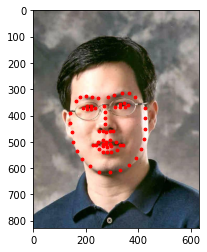

In [3]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=32, marker='.', c='r')


plt.figure(num=1, figsize=(4, 4))   
image = io.imread(os.path.join(data_path, img_name))
print("image size: ", image.shape)
show_landmarks(image,landmarks)
plt.show()


# Dataset
torch.utils.data.Dataset 是代表数据集的抽象类。自定义数据集应继承该类，并实现以下两个方法：
 * \__len\__: 便于 len(dataset) 获取数据集的大小
 * \__getitem\__: 支持索引，便于通过 dataset\[i\] 获取指定下标的数据

In [4]:
# 创建一个面部轮廓的数据集，在 __init__ 中读取 CSV 文件，在调用 __getitem__ 的时候，真正加载图片到内存
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
         self.landmarks_frame = pd.read_csv(csv_file)
         self.root_dir = root_dir
         self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_name = self.landmarks_frame.iloc[idx, 0]
        image_file = os.path.join(self.root_dir, image_name)
        image = io.imread(image_file)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.asanyarray(landmarks)
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {"image": image, "landmarks": landmarks}

        # 是否对数据进行其他处理
        if self.transform:
            sample = self.transform(sample)

        return sample


In [5]:
face_dataset = FaceLandmarksDataset(face_landmarks_csv, data_path, None)
print("total pics: ", len(face_dataset))

total pics:  69


0 (324, 215, 3) (68, 2)
1 (500, 333, 3) (68, 2)
2 (250, 258, 3) (68, 2)
3 (434, 290, 3) (68, 2)


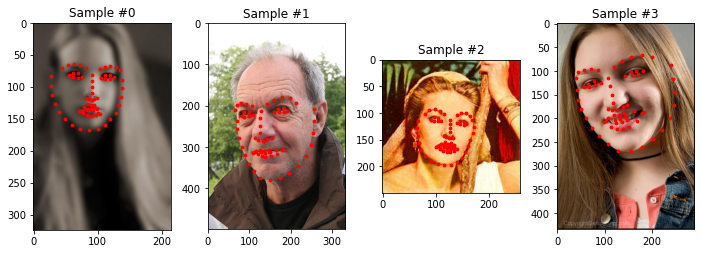

In [47]:
fig = plt.figure(1, (10, 10), dpi=72)
for i in range(len(face_landmarks_csv)):
    sample = face_dataset[i]
    print(i, sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1, 4, i+1)
    # 加上 tight_layout() 会自动调整子图的参数，让子图显示更加美观
    plt.tight_layout()
    ax.set_title("Sample #{}".format(i))
    ax.axis('on')
    show_landmarks(**sample) #show_landmarks(sample['image'], sample['landmarks'])

    if i == 3:
        plt.show()
        break

# Transforms 变换

## Question:
样本的图片大小不一致，有 500*333、250*258 等不同尺寸的数据。通常我们期望我们的数据（图像大小）固定。因此我们需要对其编写预处理的代码。
我们需要创建三个 transorm 操作
* Rescale: 图像缩放
* RandomCrop: 随机裁剪
* ToTensor: 将 numpy 的数据转换为 torch 处理的数据（交换轴：HWC  --> CHW） 

我们将其编写成可以直接调用的类，而非函数。因此我们需要实现定义这个类的 **\__call\__** 方法

In [7]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        # transpose((2, 0, 1)) --> 将之前轴2（C）换到之前轴1（H）的位置，轴1（H）和轴2（W）后移
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## 将 Transform 串起来
假设我们需要将图片的短边重新缩放到 256， 然后从中随机裁剪一个尺寸为 224 的正方形。  
这个时候我们可以将 torchvision.transforms.Compose 将其串起来执行

(333, 500, 3)


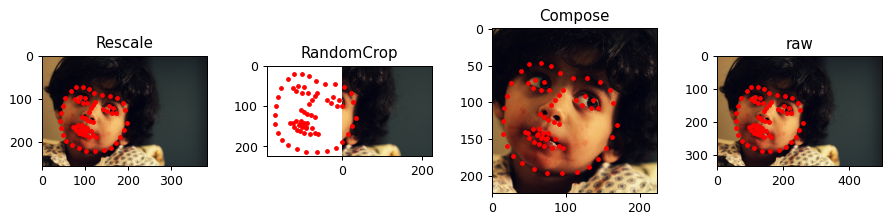

In [8]:

scale = Rescale(256)
crop = RandomCrop(224)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure(1, (10, 10), dpi=90)
sample = face_dataset[24]

# raw picture
print(sample['image'].shape)
ax = plt.subplot(1, 4, 4)
plt.tight_layout()
ax.set_title("raw")
show_landmarks(**sample)

for i, trans in enumerate([scale, crop, composed]):
    trans_sample = trans(sample)
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title(type(trans).__name__)
    show_landmarks(**trans_sample)


plt.show()


# 遍历数据集
创建具有组合 transform 的数据集。使得每次采样数据集时：
 * 从文件中即时读取图像
 * 转换应用于读取的图像
 * 由于其中一种转换时随机的，因此数据是在采样时进行增强

我们可以使用 for each 训练遍历数据集


In [9]:
transformed_dataset = FaceLandmarksDataset(csv_file=face_landmarks_csv, 
                                           root_dir=data_path, 
                                           transform=transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()]))
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].shape, sample['landmarks'].shape)
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


# For-each 遍历 datasets 的问题
* 丢失以下功能：
    * 批量处理数据
    * shuffle 数据
    * 使用 multiprocessiing 并行处理数据
* torch.utils.data.DataLoader 提供了以上功能一个迭代器


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


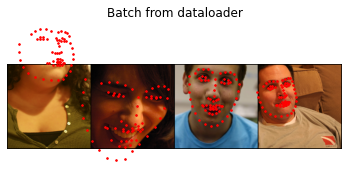

In [10]:
dataloader = DataLoader(transformed_dataset, 
                        batch_size=4,
                        shuffle=True, 
                        num_workers=4)

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    # tochvision.utils.make_grid(tensor, nrow=8, **kargs) 将 batch 的图片组成一个图片 nrow 表示一行放入几个
    grid = utils.make_grid(images_batch)

    # plt 仅接受 numpy 的数据，因此需要对 grid 的数据转成 numpy
    # plt 接受彩色图片的格式为 H*W*C, 因此还需要将 grid 交换轴
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break


# torchvision
事实上，pytorch 将上述的功能封装到 torchvision 的模块里，用户可以直接使用，包含了常见的 transforms 的 dataset.  
比较常用的是 ImageFolder. 假定图片的组织格式如下：
```
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
```

In [ ]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
my_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(my_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

# tochvision.utils.make_grid()
将 batch 的图片组成一个图片，便于展示一个 batch 的样本数据。需要注意的是，画图依然要使用 matploylib，并且：
 * 它仅接受 numpy 的数据类型，make_grid() 返回的是一个 torch.tensor 类型
 * torch 的图片格式为 CHW, matploylib 支持的格式为 HWC

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


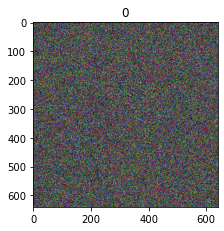

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


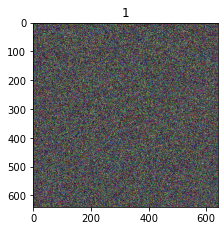

In [51]:
import torch
import torchvision
import matplotlib.pyplot as plt

w = torch.randn(2,3,640,640)
fig = plt.figure()
for i in range (0,2):
    z = w[i]
    ax = plt.subplot(1, 2, i+1)
    ax.set_title(i)
    plt.tight_layout()
    plt.imshow(z.permute(1,2,0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(840, 1580, 3)


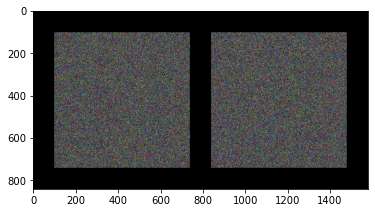

In [56]:
w.shape
grid = torchvision.utils.make_grid(w, nrow=10, padding=100)
grid_numpy_t = grid.numpy().transpose((1,2,0))
print(grid_numpy_t.shape)
plt.imshow(grid_numpy_t)